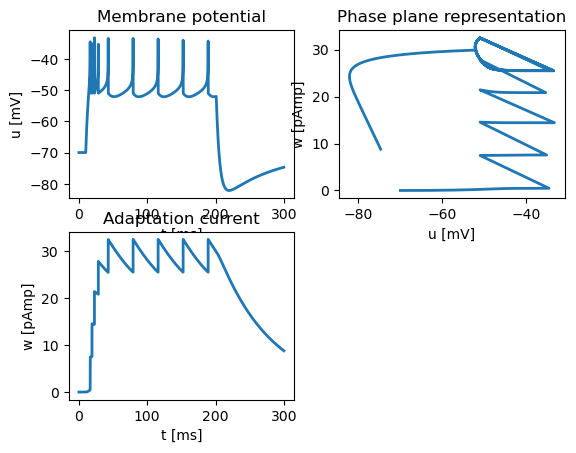

nr of spikes: 9


In [1]:
%matplotlib inline
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
from neurodynex3.adex_model import AdEx
from neurodynex3.tools import input_factory, plot_tools

AdEx.getting_started()

In [2]:
#parameters
MEMBRANE_TIME_SCALE_tau_s= 16 * b2.ms
MEMBRANE_CAPACITANCE_C = 370 * b2.pF #Vérifier pour pF
V_REST = -70.0 * b2.mV
ADAPTATION_TIME_CONSTANT_tau_w = 100.0 * b2.ms
V_RESET = -70.0 * b2.mV
SPIKE_TRIGGERED_ADAPTATION_INCREMENT_b = -200 * b2.pA
ABSOLUTE_REFRACTORY_PERIOD = 3.0 * b2.ms

#RHEOBASE_THRESHOLD_v_rh = -50.0 * b2.mV
#SHARPNESS_delta_T = 2.0 * b2.mV
#ADAPTATION_VOLTAGE_COUPLING_a = 0.5 * b2.nS

# a technical threshold to tell the algorithm when to reset vm to v_reset
FIRING_THRESHOLD_v_spike = -50*b2.mV

In [3]:
# This function implement Adaptive Exponential Leaky Integrate-And-Fire neuron model

def simulate_soma(
        tau_s=MEMBRANE_TIME_SCALE_tau_s,
        C=MEMBRANE_CAPACITANCE_C,
        v_rest=V_REST,
        tau_w=ADAPTATION_TIME_CONSTANT_tau_w,
        I_stim=input_factory.get_zero_current(),
        v_reset=V_RESET,
        b=SPIKE_TRIGGERED_ADAPTATION_INCREMENT_b,
        v_spike=FIRING_THRESHOLD_v_spike,
        abs_refractory_period=ABSOLUTE_REFRACTORY_PERIOD,

        #v_rheobase=RHEOBASE_THRESHOLD_v_rh,
        #a=ADAPTATION_VOLTAGE_COUPLING_a,
        #delta_T=SHARPNESS_delta_T,

        simulation_time=200 * b2.ms):
    r"""
    Implementation of the AdEx model with a single adaptation variable w.

    The Brian2 model equations are:

    .. math::

        \tau_m \frac{dv}{dt} = -(v-v_{rest}) + \Delta_T \cdot
                                e^{\frac{v-v_{rheobase}}{\Delta_T}} + R I_{stim}(t,i) - R w \\
        \tau_w \frac{dw}{dt} = a (v-v_{rest}) - w

    Args:
        tau_m (Quantity): membrane time scale
        R (Quantity): membrane restistance
        v_rest (Quantity): resting potential
        v_reset (Quantity): reset potential
        v_rheobase (Quantity): rheobase threshold
        a (Quantity): Adaptation-Voltage coupling
        b (Quantity): Spike-triggered adaptation current (=increment of w after each spike)
        v_spike (Quantity): voltage threshold for the spike condition
        delta_T (Quantity): Sharpness of the exponential term
        tau_w (Quantity): Adaptation time constant
        I_stim (TimedArray): Input current
        simulation_time (Quantity): Duration for which the model is simulated

    Returns:
        (state_monitor, spike_monitor):
        A b2.StateMonitor for the variables "v" and "w" and a b2.SpikeMonitor
    """

    v_spike_str = "v>{:f}*mvolt".format(v_spike / b2.mvolt)

    # EXP-IF
    eqs = """
        dv/dt = -(v-v_rest)/tau_s + (I_stim(t,i) + w)/C : volt (unless refractory)
        dw/dt=-w/tau_w : amp
        """

    neuron = b2.NeuronGroup(1, model=eqs, threshold=v_spike_str, reset="v=v_reset;w+=b",refractory=abs_refractory_period, method="euler")

    # initial values of v and w is set here:
    neuron.v = v_rest
    neuron.w = 0.0 * b2.pA

    # Monitoring membrane voltage (v) and w
    state_monitor = b2.StateMonitor(neuron, ["v", "w"], record=True)
    spike_monitor = b2.SpikeMonitor(neuron)

    # running simulation
    b2.run(simulation_time)
    return state_monitor, spike_monitor

def plot_adex_state(adex_state_monitor):
    """
    Visualizes the state variables: w-t, v-t and phase-plane w-v

    Args:
    adex_state_monitor (StateMonitor): States of "v" and "w"
    """
    plt.subplot(2, 2, 1)
    plt.plot(adex_state_monitor.t / b2.ms, adex_state_monitor.v[0] / b2.mV, lw=2)
    plt.xlabel("t [ms]")
    plt.ylabel("u [mV]")
    plt.title("Membrane potential")
    plt.subplot(2, 2, 2)
    plt.plot(adex_state_monitor.v[0] / b2.mV, adex_state_monitor.w[0] / b2.pA, lw=2)
    plt.xlabel("u [mV]")
    plt.ylabel("w [pAmp]")
    plt.title("Phase plane representation")
    plt.subplot(2, 2, 3)
    plt.plot(adex_state_monitor.t / b2.ms, adex_state_monitor.w[0] / b2.pA, lw=2)
    plt.xlabel("t [ms]")
    plt.ylabel("w [pAmp]")
    plt.title("Adaptation current")
    plt.show()

nr of spikes: 4


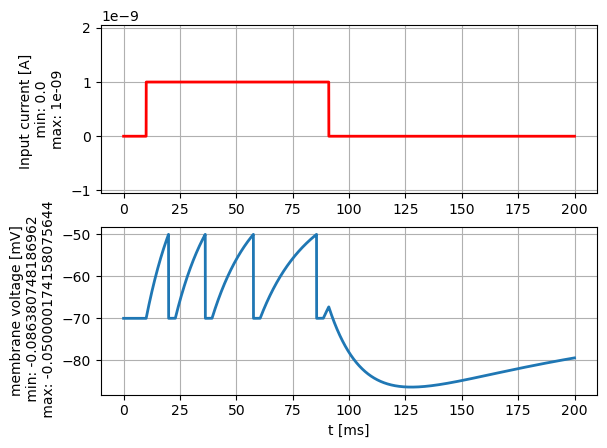

In [4]:
current = input_factory.get_step_current(10, 90, 1. * b2.ms, 1000.0 * b2.pA)
state_monitor, spike_monitor = simulate_soma(I_stim=current)
plot_tools.plot_voltage_and_current_traces(state_monitor, current)
print("nr of spikes: {}".format(spike_monitor.count[0]))

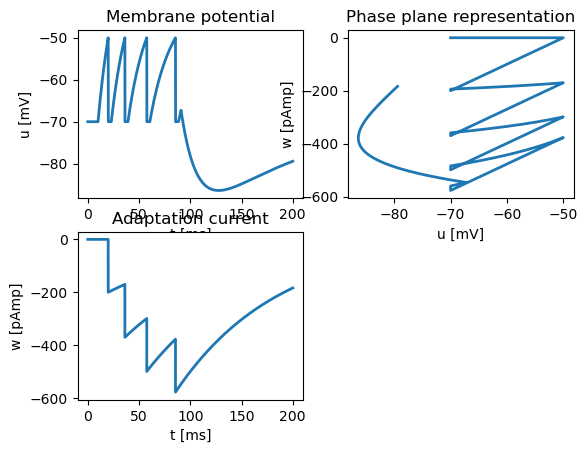

In [5]:
plot_adex_state(state_monitor)